# Отчёт по лабораторной работе №4 "Нейронные сети"

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt


DATA_FILE_NAME_1 = 'Lab 4/ex4data1'
DATA_FILE_NAME_2 = 'Lab 4/ex4weights'

Imports from 'common' file:

In [2]:
import os
from scipy.io import loadmat

DATA_DIRECTORY = '../Data/'


def load_data_from_mat_file(filename, directory=DATA_DIRECTORY):
    filepath = directory + f'{filename}.mat'
    return loadmat(filepath)

def __convert_to_2d(X):
    try:
        X.shape[1]
        return X, False
    except IndexError:
        return np.array([X]).T, True


def extend_x(X):
    X, transposed = __convert_to_2d(X)
    return np.concatenate((np.array([np.ones(X.shape[0])]).T, X), axis=1)


def flatten_array_of_objects(X):
    return np.hstack([x.flatten() for x in X])

### 1. Загрузите данные ​ ex4data1.mat ​ из файла.

In [3]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_1)
X = df_data['X']
E_X = extend_x(X)
Y = df_data['y']

### 2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?

In [4]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_2)
Theta1 = df_data['Theta1']
Theta2 = df_data['Theta2']
Thetas = np.array([Theta1, Theta2])

Нейронная сеть состоит из трёх слоёв: входной слой содержит 400 нейронов, один скрытый слой - 25 и выходной - 10 нейронов.

### 3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации.

In [5]:
def sigmoid_function(X):
    return 1. / (1 + np.exp(-X))


def forward_propagation_step(X, Thetas, activation_function=sigmoid_function):
    new_a_list = [X.copy().T]
    for ind, theta in enumerate(Thetas):
        Z = theta.dot(extend_x(new_a_list[-1].T).T)
        new_a_list.append(activation_function(Z))

    return np.array(new_a_list)

### 4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [8]:
def check_prediction_accuracy(H, Y):
    true_predictions = 0
    for index, value in enumerate(Y):
        if H[index] + 1 == value:
            true_predictions += 1

    return true_predictions / len(Y)


def check_prediction_accuracy_with_fp(X, Thetas, Y):
    A = forward_propagation_step(X, Thetas)
    class_predictions = np.argmax(A[-1], axis=0)
    return check_prediction_accuracy(class_predictions, Y[:, 0])


print('prediction accuracy:', check_prediction_accuracy_with_fp(X, Thetas, Y))

prediction accuracy: 0.9752


Как видим, точность вычислений очень низкая. Это связно с тем, что исходные веса не позволяют добиться хорошего
результата. А значит нейронную сеть стоит обучить для вычисления наиболее оптимальных весов.
Заметим, что логистическая регресия давала нам точность 0.9588.

### 5. Перекодируйте исходные метки классов по схеме one-hot.

In [12]:
classes_num = 10

one_hot_Y = np.zeros((Y.shape[0], classes_num))
for ind, value in enumerate(Y[:, 0]):
    one_hot_Y[ind][value - 1] = 1

Y.shape, one_hot_Y.shape

((5000, 1), (5000, 10))

### 6. Реализуйте функцию стоимости для данной нейронной сети.

In [13]:
def cost_function(H, Y):
    return -(Y.dot(np.log(H).T) + (np.ones(Y.shape) - Y).dot(np.log(np.ones(H.shape) - H).T)).sum(axis=0) / len(Y)


def get_cost_function(X, Y, activation_function=sigmoid_function):
    def func(Thetas):
        A = forward_propagation_step(X, Thetas, activation_function)
        return cost_function(A[-1].T, Y)
    return func

### 7. Добавьте L2-регуляризацию в функцию стоимости.

In [15]:
def cost_function_with_reg(H, Y, Thetas, reg_param):
    R = [(np.square(theta) * reg_param).sum() for theta in Thetas]
    return cost_function(H, Y) + sum(R) / len(Y)


def get_cost_function_with_reg(X, Y, reg_param, activation_function=sigmoid_function):
    def func(Thetas):
        A = forward_propagation_step(X, Thetas, activation_function)
        return cost_function_with_reg(A[-1].T, Y, Thetas, reg_param)
    return func

### 8. Реализуйте функцию вычисления производной для функции активации.

In [16]:
def sigmoid_derivative_function(X):
    a = sigmoid_function(X)
    return np.multiply(a, (np.ones(a.shape) - a))

### 9. Инициализируйте веса небольшими случайными числами.

In [19]:
def get_random_Thetas():
    init_eps = 1e-3
    return np.array([
        np.random.rand(*Theta1.shape) * 2 * init_eps - init_eps,
        np.random.rand(*Theta2.shape) * init_eps - init_eps
    ])


random_Thetas = get_random_Thetas()
[random_Theta.shape for random_Theta in random_Thetas]

[(25, 401), (10, 26)]

### 10.Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [22]:
def back_propagation(Thetas, X, Y):
    A = forward_propagation_step(X, Thetas)
    M = Y.shape[0]
    deltas = [A[-1] - Y.T]
    for l in reversed(range(1, len(A) - 1)):
        derivative = sigmoid_derivative_function(A[l])
        delta = np.multiply(Thetas[l].T.dot(deltas[0]), extend_x(derivative.T).T)
        deltas.insert(0, delta[1:])

    return np.array([delta.dot(A[i].T) for i, delta in enumerate(deltas)]) / M

grads = back_propagation(Thetas, X, one_hot_Y)
[grad.shape for grad in grads]

[(25, 400), (10, 25)]

### 11.Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10^-4.

In [24]:
GRAD_EPS = 1e-4


def check_gradient(X, Y, Thetas, Grads, activation_function=sigmoid_function, max_iterations=500):
    cost_function = get_cost_function(X, Y, activation_function)
    grad_vector = flatten_array_of_objects(Grads)
    iteration = 0
    grad_approx = []
    try:
        for l in range(Thetas.shape[0]):
            for i in range(Thetas[l].shape[0]):
                for j in range(Thetas[l].shape[1]):
                    Theta_l_plus = Thetas.copy()
                    Theta_l_plus[l][i, j] += GRAD_EPS
                    Theta_l_minus = Thetas.copy()
                    Theta_l_minus[l][i, j] -= GRAD_EPS
                    grad_approx_i = ((cost_function(Theta_l_plus) - cost_function(Theta_l_minus)) / 2 / GRAD_EPS).sum()
                    grad_approx.append(grad_approx_i)

                    iteration += 1
                    if max_iterations < iteration:
                        raise Exception
    except Exception:
        pass

    grad_approx = np.array(grad_approx)
    if grad_approx.size < grad_vector.size:
        temp = np.zeros(grad_vector.size)
        temp[:grad_approx.size] = grad_approx
        grad_approx = temp

    return np.allclose(grad_approx, grad_vector, atol=1)

print('gradient check:', check_gradient(X, one_hot_Y, Thetas, grads))

gradient check True


### 12.Добавьте L2-регуляризацию в процесс вычисления градиентов.

In [25]:
def back_propagation_with_reg(Thetas, X, Y, reg_param):
    D = back_propagation(Thetas, X, Y)
    M = Y.shape[0]
    return D + np.array([theta[:, 1:] for theta in Thetas]) * reg_param / M


grads_with_reg = back_propagation_with_reg(Thetas, X, one_hot_Y, 1)
[grad_with_reg.shape for grad_with_reg in grads_with_reg]

[(25, 400), (10, 25)]

### 13.Проверьте полученные значения градиента.

In [26]:
print('gradient with reg check:', check_gradient(X, one_hot_Y, Thetas, grads_with_reg))

gradient with reg check: True


### 14.Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [39]:
def gradient_descent_function_with_reg(Thetas, X, Y, reg_param=0, learning_rate=0.5, eps=1e-4, iteration_count=1e3):
    iteration = 0
    theta_list = Thetas.copy()
    flatten_theta_gradient = [eps + 1]

    while any([abs(t) > eps for t in flatten_theta_gradient]) and iteration < iteration_count:
        theta_gradient = back_propagation_with_reg(theta_list, X, Y, reg_param)
        # checking = check_gradient(X, Y, theta_list, theta_gradient)
        # print('checking', checking)
        for l, theta in enumerate(theta_list):
            theta[:, 1:] -= learning_rate * theta_gradient[l]

        flatten_theta_gradient = flatten_array_of_objects(theta_gradient)
        iteration += 1

    return theta_list, not any([abs(t) > eps for t in flatten_theta_gradient]), iteration


Thetas_with_reg, success, iteration = gradient_descent_function_with_reg(random_Thetas, X, one_hot_Y, reg_param=0.003)

print('Backpropagation algorithm with L2 regularization:')
print('success', success)
print('iteration', iteration, '\n')


Backpropagation algorithm with L2 regularization:
success False
iteration 1000 



### 15.Вычислите процент правильных классификаций на обучающей выборке.

In [38]:
print('prediction accuracy:', f'{check_prediction_accuracy_with_fp(X, Thetas_with_reg, Y) * 100}%', '\n')

prediction accuracy: 78.28% 



### 16.Визуализируйте скрытый слой обученной сети.

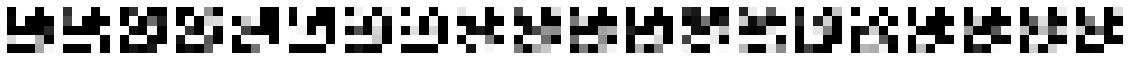

In [32]:
def plot_hidden_layer(X, Thetas):
    A = forward_propagation_step(X, Thetas)
    hidden_layer = A[1].T
    nums = list(range(150, 5000, 250))
    size = int(np.sqrt(hidden_layer.shape[1]))
    pictures = [hidden_layer[i].reshape((size, size)) for i in nums]
    fig, axs = plt.subplots(1, 20, figsize=(20, 0.85))
    for i, ax in enumerate(axs.flatten()):
        ax.pcolor(pictures[i], cmap=cm.gray)
        ax.axis('off')

    plt.show()


plot_hidden_layer(X, Thetas_with_reg)

### 17.Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

reg_param: 5 

prediction accuracy: 0.7908


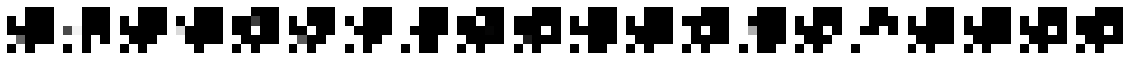

reg_param: 1 

prediction accuracy: 0.795


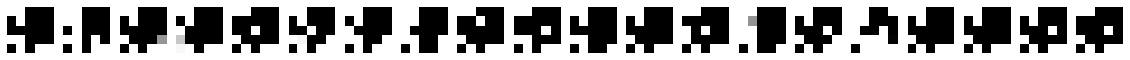

reg_param: 0.9 

prediction accuracy: 0.8014


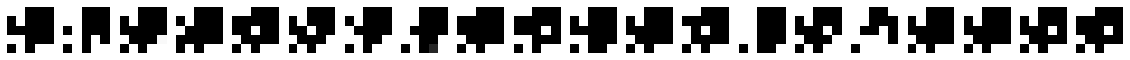

reg_param: 0.8 

prediction accuracy: 0.799


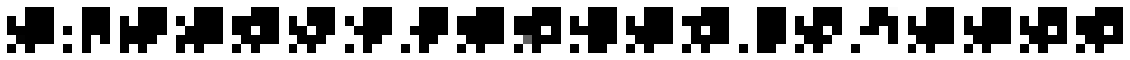

reg_param: 0.7 

prediction accuracy: 0.7958


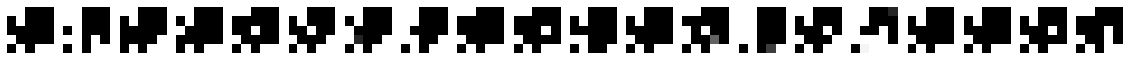

reg_param: 0.6 

prediction accuracy: 0.791


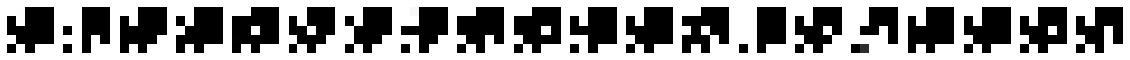

reg_param: 0.5 

prediction accuracy: 0.7838


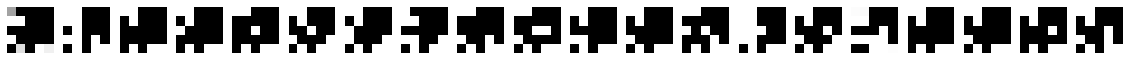

reg_param: 0.3 

prediction accuracy: 0.7792


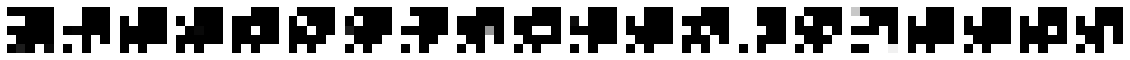

reg_param: 0.1 

prediction accuracy: 0.8018


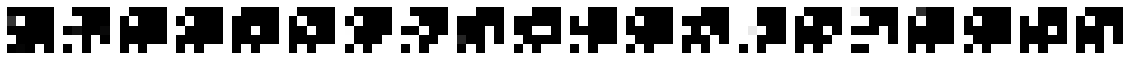

reg_param: 0.05 

prediction accuracy: 0.7732


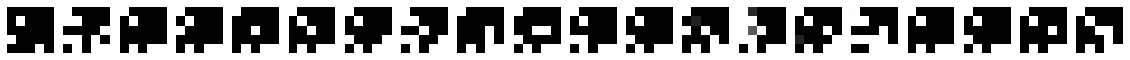

reg_param: 0.01 

prediction accuracy: 0.7606


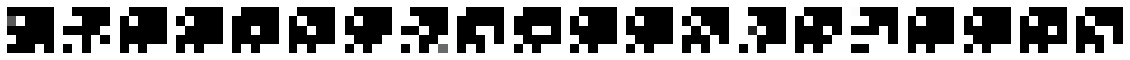

reg_param: 0 

prediction accuracy: 0.7712


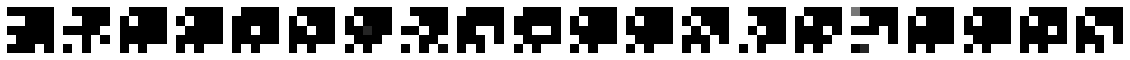

the best value is 0.1


In [40]:
reg_params_list = [5, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3, 0.1, 0.05, 0.01, 0]
reg_params_map = {}

for i, reg_param in enumerate(reg_params_list):
    Thetas_with_reg, success, iteration = gradient_descent_function_with_reg(
        random_Thetas, X, one_hot_Y, reg_param=reg_param)
    reg_params_map[reg_param] = check_prediction_accuracy_with_fp(X, Thetas_with_reg, Y)
    print('reg_param:', reg_param, '\n')
    print('prediction accuracy:', reg_params_map[reg_param])
    plot_hidden_layer(X, Thetas_with_reg)
    
best_reg_param = max(reg_params_map, key=reg_params_map.get)
print(f'the best value is {best_reg_param}')

О хорошо подобранном параметре регуляризации свидетельствуют изображения на скрытом слое: чем более
разряженны изображения, тем лучше подобран параметр. Разряженные изображения несут мало информации о своём
визуальном контенте изображения, но они дают нейронной сети больше информации о том, к какому классу они
принадлежат. Также высокая точность нейронной сети свидетельствует о хорошо подобранном параметре
регуляризации.